In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mohamedhanyyy/chest-ctscan-images")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/chest-ctscan-images


In [563]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import os
import keras
import warnings
from sklearn.decomposition import *
from sklearn.manifold import *
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, ReLU, Flatten, Dense, Dropout, Input
from keras.callbacks import EarlyStopping
import tensorflow as tf
from keras import regularizers
from keras.applications import ResNet50, VGG16, DenseNet121, EfficientNetV2L, InceptionV3
import albumentations as A
import cv2
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
warnings.filterwarnings('ignore')
sns.set()

In [3]:
os.listdir('/kaggle/input/chest-ctscan-images')

['Data']

In [4]:
os.listdir('/kaggle/input/chest-ctscan-images/Data')

['valid', 'test', 'train']

In [5]:
os.listdir('/kaggle/input/chest-ctscan-images/Data/train')

['squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa',
 'normal',
 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa',
 'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib']

In [6]:
train_dataset = keras.preprocessing.image_dataset_from_directory(
    directory = '/kaggle/input/chest-ctscan-images/Data/train',
    batch_size = 32,
    image_size = (80, 80),
    shuffle = True
)

Found 613 files belonging to 4 classes.


I0000 00:00:1745576823.861585      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1745576823.862347      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [7]:
class_names = train_dataset.class_names
print(f'Classes in the dataset: {class_names}')
print(f'Number of classes in the dataset: {len(class_names)}')
print(f'Number of batches in the training set: {len(train_dataset)}')
for images, labels in train_dataset.take(1):
    print(f'Batch size: {len(images)}')
    print(f'Shape of images: {images[0].shape}')

Classes in the dataset: ['adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib', 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa', 'normal', 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa']
Number of classes in the dataset: 4
Number of batches in the training set: 20
Batch size: 32
Shape of images: (80, 80, 3)


In [8]:
def data_extractor(path):
    dataset = keras.preprocessing.image_dataset_from_directory(
        directory = path,
        batch_size = 32,
        image_size = (80, 80),
        shuffle = False
    )
    return dataset

In [9]:
test_dataset = data_extractor('/kaggle/input/chest-ctscan-images/Data/test')

Found 315 files belonging to 4 classes.


In [10]:
valid_dataset = data_extractor('/kaggle/input/chest-ctscan-images/Data/valid')

Found 72 files belonging to 4 classes.


In [11]:
print(f'Number of batches in the test dataset: {len(test_dataset)}')
print(f'Number of batches in the validation dataset: {len(valid_dataset)}')

Number of batches in the test dataset: 10
Number of batches in the validation dataset: 3


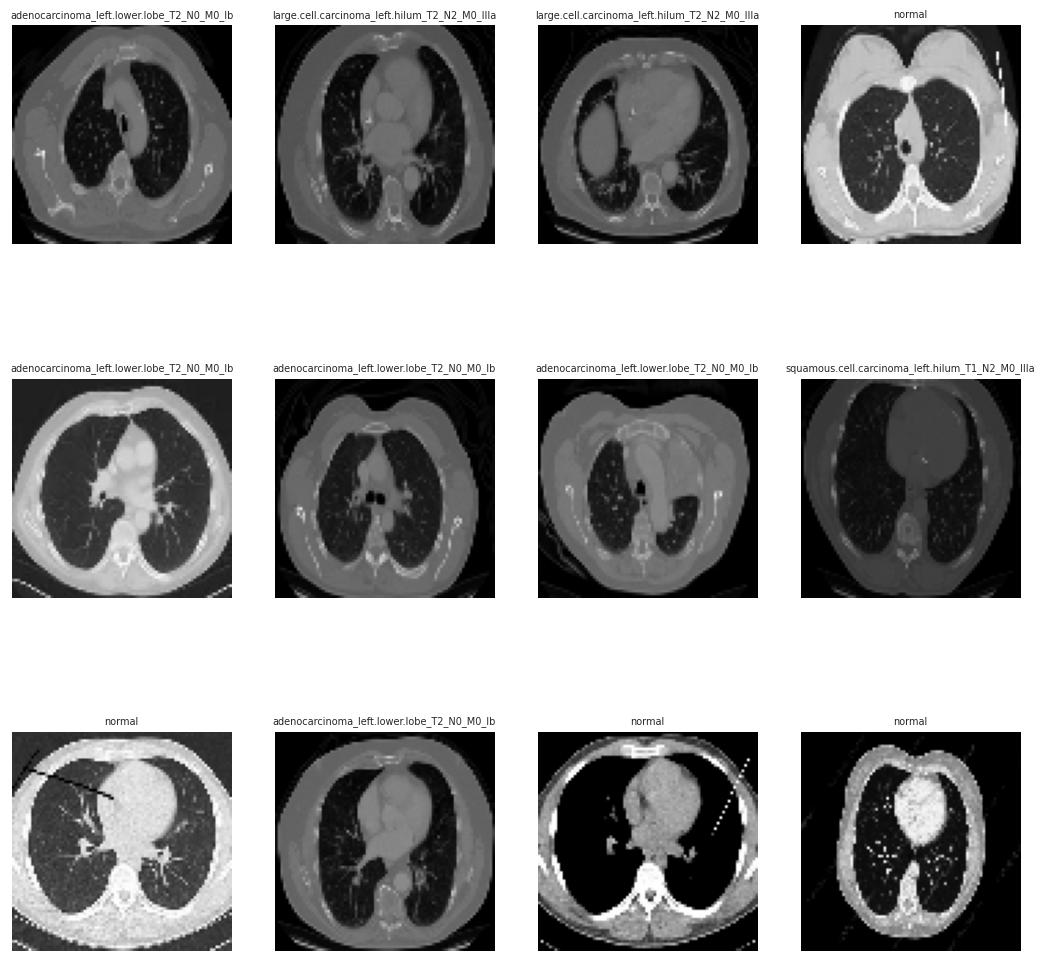

In [14]:
plt.figure(figsize = (13, 13))
for images, labels in train_dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(images[i].numpy().astype('uint32'))
        plt.title(class_names[labels[i].numpy()], fontsize = 7)
        plt.axis('off')

In [12]:
images, labels = [], []
for images_batch, labels_batch in train_dataset:
    images.append(images_batch.numpy())
    labels.append(labels_batch.numpy())

In [13]:
images_array = np.concatenate(images)
labels_array = np.concatenate(labels)

In [14]:
images_array[0]

array([[[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       [[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.05390611, 0.05390611, 0.05390611],
        ...,
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       [[0.30078125, 0.30078125, 0.30078125],
        [0.02734375, 0.02734375, 0.02734375],
        [0.        , 0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        ],
        [0.84765625, 0.84765625, 0.84765625],
        [0.        , 0.        , 0.        ]],

       ...,

       [[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0

In [32]:
dim_redu_algs = {'PCA': PCA, 'KernelPCA': KernelPCA, 'SparsePCA': SparsePCA, 'MiniBatchSparsePCA': MiniBatchSparsePCA, 'FastICA': FastICA, 
                'LatentDirichletAllocation': LatentDirichletAllocation, 'tSNE': TSNE, 'MDS': MDS}

In [40]:
def dimensionality_reduction(name, alg, images, labels):
    al = alg(n_components = 2)
    images_reshaped = images.reshape(images.shape[0], -1)
    data_tr = al.fit_transform(images_reshaped)
    plt.figure(figsize = (7, 5))
    plt.scatter(data_tr[:,0], data_tr[:, 1], c = labels, cmap = 'tab10', s = 4)
    plt.title(name, fontsize = 15)
    plt.show()

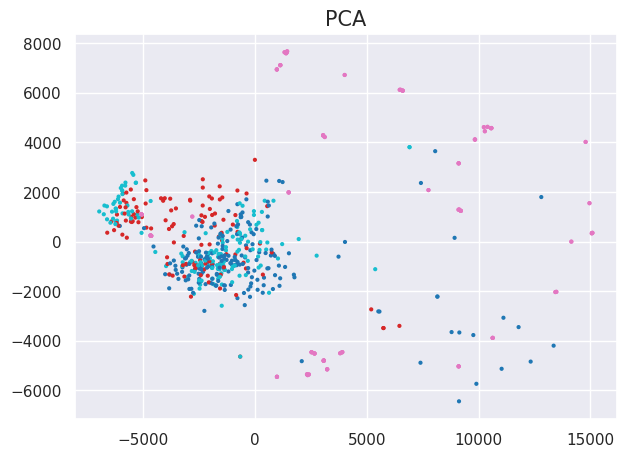

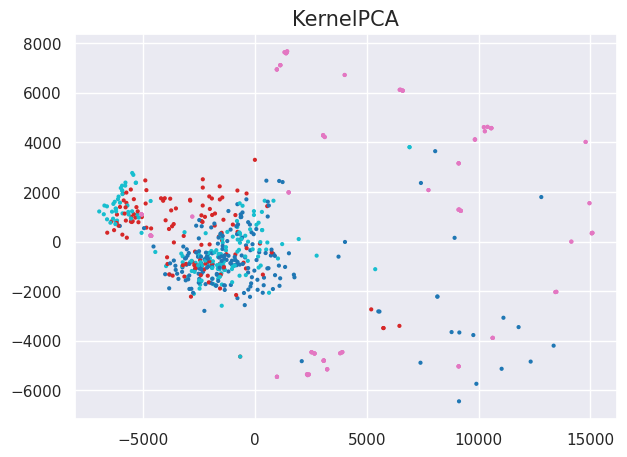

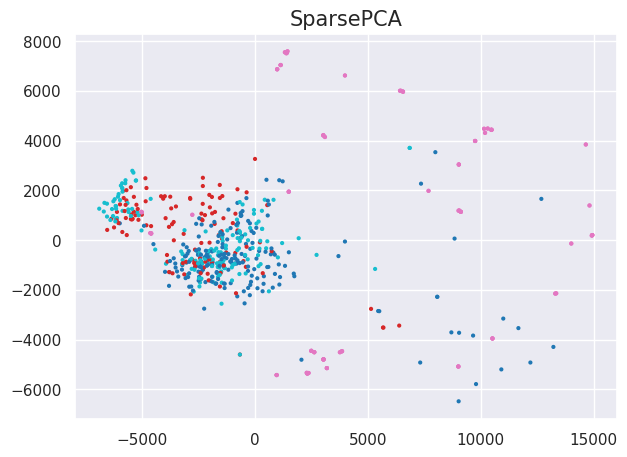

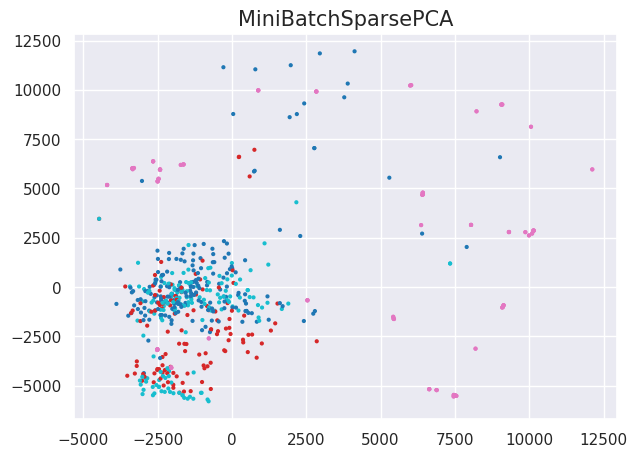

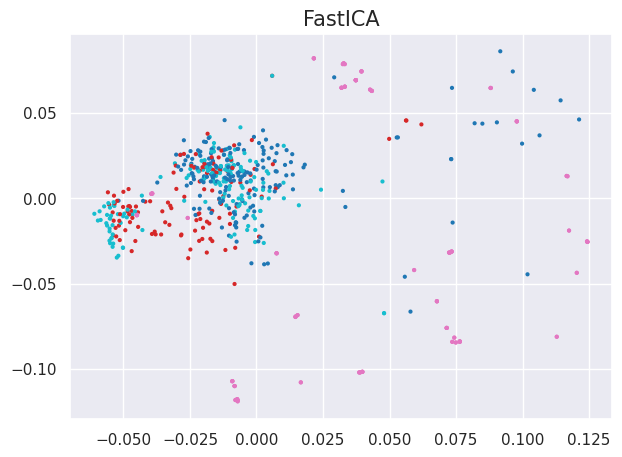

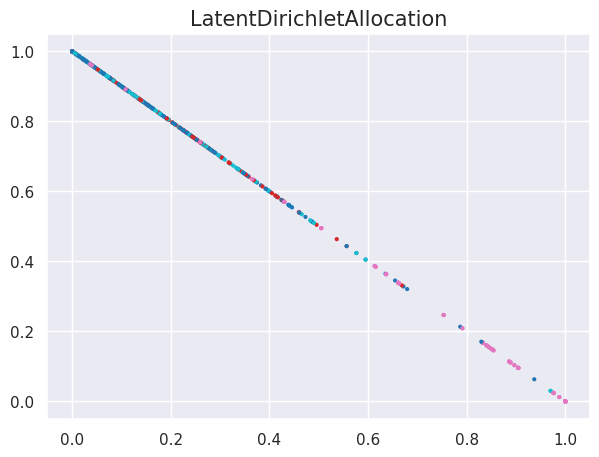

OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detec

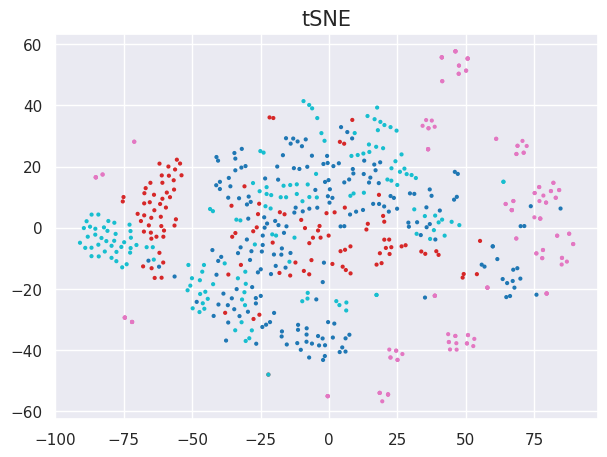

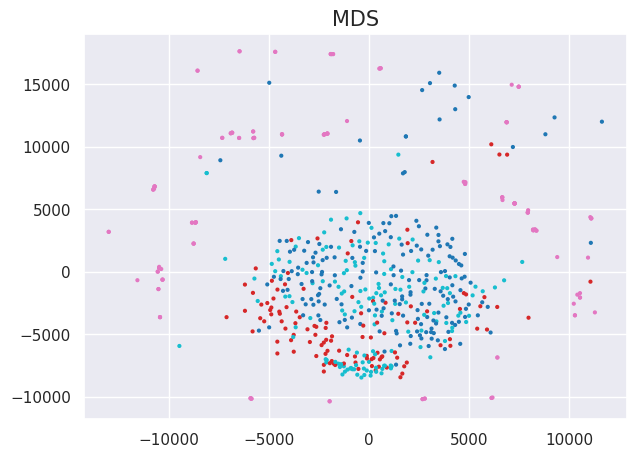

In [41]:
for name, algorithm in dim_redu_algs.items():
    dimensionality_reduction(name, algorithm, images_array, labels_array)

In [14]:
train_dataset = train_dataset.map(lambda x, y: (x / 255, y))

In [15]:
test_dataset = test_dataset.map(lambda x, y: (x / 255, y))

In [16]:
valid_dataset = valid_dataset.map(lambda x, y: (x / 255, y))

In [17]:
train_dataset = train_dataset.cache().prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.cache().prefetch(tf.data.AUTOTUNE)

In [19]:
model = Sequential()

In [20]:
model.add(Input(shape = (80, 80, 3)))
model.add(Conv2D(128, (3, 3), padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Conv2D(64, (3, 3), padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Flatten())
model.add(Dense(64, activation = 'relu'))
model.add(Dense(len(class_names), activation = 'softmax'))

In [21]:
model.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

In [22]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 80, 80, 128)         │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 40, 40, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 40, 40, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 20, 20, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       1,638,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,716,100 (6.55 MB)

 Trainable params: 1,716,100 (6.55 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 2)

In [25]:
history = model.fit(train_dataset, validation_data = valid_dataset, epochs = 100, callbacks = [early_stopping])

Epoch 1/100


I0000 00:00:1745506331.485067     101 service.cc:148] XLA service 0x7f1b00005140 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745506331.485986     101 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1745506331.486005     101 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1745506331.833325     101 cuda_dnn.cc:529] Loaded cuDNN version 90300


 9/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2535 - loss: 1.3888

I0000 00:00:1745506334.710968     101 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 174ms/step - accuracy: 0.3398 - loss: 1.3167 - val_accuracy: 0.4722 - val_loss: 1.0721
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7057 - loss: 0.8149 - val_accuracy: 0.6111 - val_loss: 0.8484
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8416 - loss: 0.4527 - val_accuracy: 0.6111 - val_loss: 0.7604
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8810 - loss: 0.3271 - val_accuracy: 0.7361 - val_loss: 0.6671
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8927 - loss: 0.2851 - val_accuracy: 0.6389 - val_loss: 0.8032
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9005 - loss: 0.2204 - val_accuracy: 0.7639 - val_loss: 0.5618
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9272 - loss: 0.2212 - val_accuracy: 0.7639 - val_loss: 0.5763
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9529 - loss: 0.1390 - val_accuracy: 0.7778 - val_

In [490]:
def plot_results(train_losses, train_accs, valid_losses, valid_accs):
    fig, axes = plt.subplots(1, 2, figsize = (15, 5))
    xs = np.arange(1, len(train_losses) + 1, 1)
    axes[0].plot(xs, train_losses, label = 'Train')
    axes[0].plot(xs, valid_losses, label = 'Validation')
    axes[0].set_title('Loss', fontsize = 15)
    axes[0].set_xlabel('Epoch', fontsize = 10)
    axes[0].set_ylabel('Loss', fontsize = 10)
    axes[0].set_xticks(xs)
    axes[1].plot(xs, train_accs, label = 'Train')
    axes[1].plot(xs, valid_accs, label = 'Valid')
    axes[1].set_title('Accuracy', fontsize = 15)
    axes[1].set_xlabel('Epoch', fontsize = 10)
    axes[1].set_ylabel('Accuracy', fontsize = 10)
    axes[1].set_xticks(xs)
    plt.tight_layout()
    plt.legend()
    plt.show()

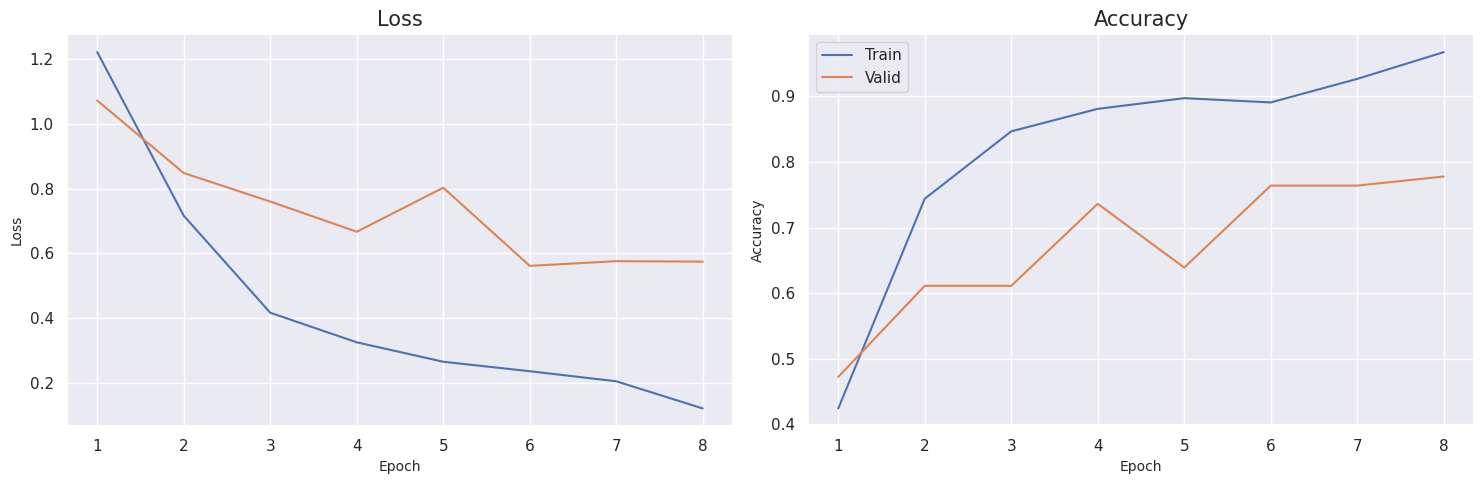

In [28]:
plot_results(history.history['loss'], history.history['accuracy'], history.history['val_loss'], history.history['val_accuracy'])

In [31]:
model2 = Sequential()

In [32]:
model2.add(Input(shape = (80, 80, 3)))
model2.add(Conv2D(64, (3, 3), padding = 'same', activation = 'relu'))
model2.add(MaxPooling2D(pool_size = (2, 2)))
model2.add(Conv2D(32, (3, 3), activation = 'relu'))
model2.add(MaxPooling2D(pool_size = (2, 2)))
model2.add(Flatten())
model2.add(Dense(64, activation = 'relu'))
model2.add(Dense(len(class_names), activation = 'softmax'))

In [33]:
model2.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

In [34]:
model2.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 80, 80, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 40, 40, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 38, 38, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 19, 19, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 11552)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │         739,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 759,908 (2.90 MB)

 Trainable params: 759,908 (2.90 MB)

 Non-trainable params: 0 (0.00 B)

In [35]:
early_stopping2 = EarlyStopping(monitor = 'val_loss', patience = 2)

In [36]:
history2 = model2.fit(train_dataset, validation_data = valid_dataset, epochs = 100, callbacks = [early_stopping2])

Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 114ms/step - accuracy: 0.3896 - loss: 1.2977 - val_accuracy: 0.5278 - val_loss: 1.0482
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6805 - loss: 0.8696 - val_accuracy: 0.6389 - val_loss: 0.8356
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8333 - loss: 0.5094 - val_accuracy: 0.6528 - val_loss: 0.7875
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8481 - loss: 0.4115 - val_accuracy: 0.6944 - val_loss: 0.7677
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8393 - loss: 0.4268 - val_accuracy: 0.7778 - val_loss: 0.5572
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8846 - loss: 0.2980 - val_accuracy: 0.7778 - val_loss: 0.5809
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9370 - loss: 0.1963 - val_accuracy: 0.7778 - val_loss: 0.5867


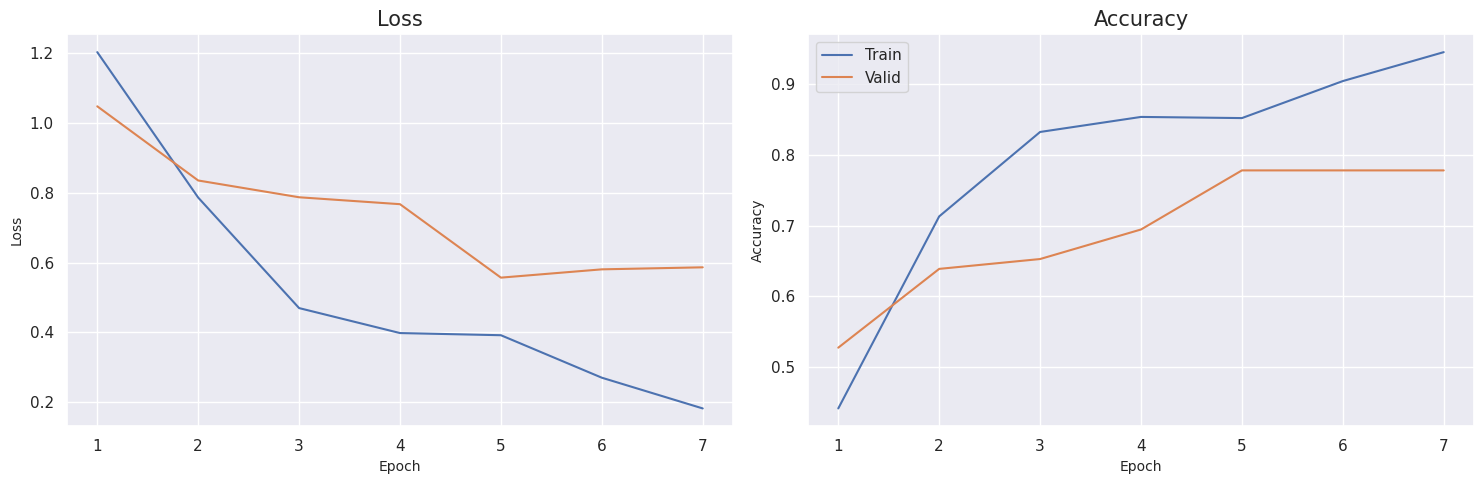

In [37]:
plot_results(history2.history['loss'], history2.history['accuracy'], history2.history['val_loss'], history2.history['val_accuracy'])

In [45]:
model3 = Sequential()

In [46]:
model3.add(Input(shape = (80, 80, 3)))
model3.add(Conv2D(16, (3, 3), padding = 'same', activation = 'relu'))
model3.add(MaxPooling2D(pool_size = (2, 2)))
model3.add(Flatten())
model3.add(Dense(len(class_names), activation = 'softmax'))

In [47]:
model3.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

In [48]:
model3.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                    │ (None, 80, 80, 16)          │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 40, 40, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 25600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 4)                   │         102,404 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 102,852 (401.77 KB)

 Trainable params: 102,852 (401.77 KB)

 Non-trainable params: 0 (0.00 B)

In [49]:
early_stopping3 = EarlyStopping(monitor = 'val_loss', patience = 2)

In [50]:
history3 = model3.fit(train_dataset, validation_data = valid_dataset, epochs = 100, callbacks = [early_stopping3])

Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - accuracy: 0.3636 - loss: 1.7325 - val_accuracy: 0.5278 - val_loss: 1.2018
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7039 - loss: 0.8257 - val_accuracy: 0.5972 - val_loss: 0.9613
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8517 - loss: 0.5675 - val_accuracy: 0.6111 - val_loss: 0.8133
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8942 - loss: 0.4154 - val_accuracy: 0.6667 - val_loss: 0.7193
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9154 - loss: 0.3276 - val_accuracy: 0.7222 - val_loss: 0.6752
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9382 - loss: 0.2545 - val_accuracy: 0.7361 - val_loss: 0.6459
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9490 - loss: 0.2053 - val_accuracy: 0.7361 - val_loss: 0.6434
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9678 - loss: 0.1639 - val_accuracy: 0.7639 - 

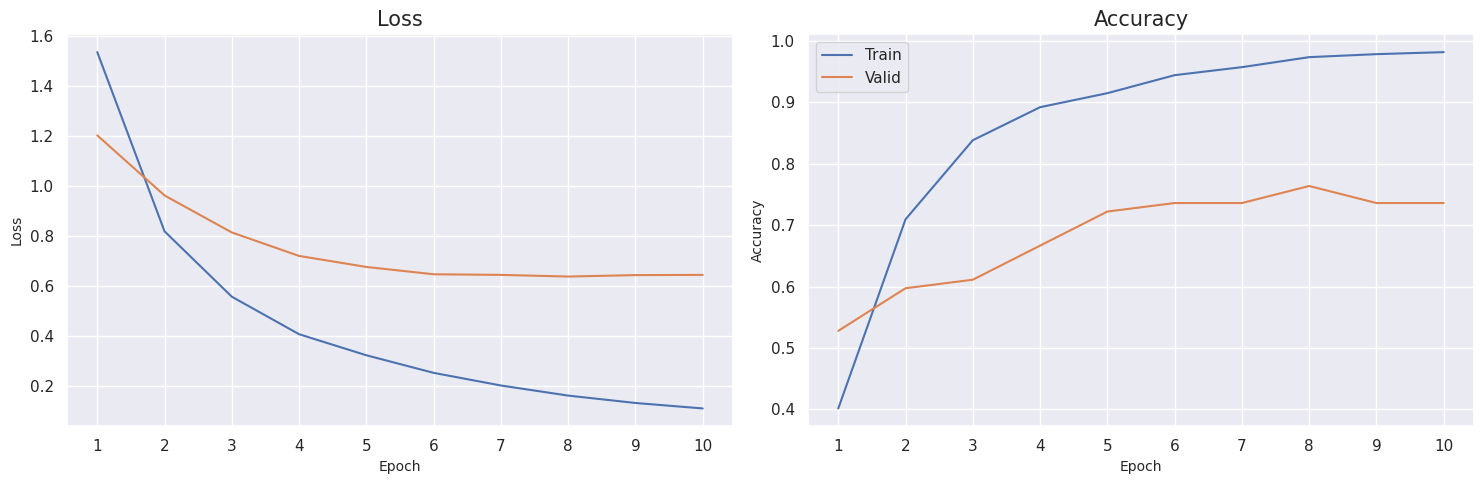

In [52]:
plot_results(history3.history['loss'], history3.history['accuracy'], history3.history['val_loss'], history3.history['val_accuracy'])

In [69]:
model4 = Sequential()

In [70]:
model4.add(Input(shape = (80, 80, 3)))
model4.add(Conv2D(16, (3, 3), padding = 'same', activation = 'relu'))
model4.add(MaxPooling2D(pool_size = (2, 2)))
model4.add(Flatten())
model4.add(Dropout(0.5))
model4.add(Dense(len(class_names), activation = 'softmax'))

In [71]:
model4.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

In [72]:
model4.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)                   │ (None, 80, 80, 16)          │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 40, 40, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 25600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 25600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 4)                   │         102,404 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 102,852 (401.77 KB)

 Trainable params: 102,852 (401.77 KB)

 Non-trainable params: 0 (0.00 B)

In [73]:
early_stopping4 = EarlyStopping(monitor = 'val_loss', patience = 2)

In [74]:
history4 = model4.fit(train_dataset, validation_data = valid_dataset, epochs = 100, callbacks = [early_stopping4])

Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - accuracy: 0.3158 - loss: 1.5952 - val_accuracy: 0.4861 - val_loss: 1.1854
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6731 - loss: 0.9338 - val_accuracy: 0.5833 - val_loss: 0.9547
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7976 - loss: 0.6691 - val_accuracy: 0.6528 - val_loss: 0.8091
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8613 - loss: 0.4861 - val_accuracy: 0.6944 - val_loss: 0.7404
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8765 - loss: 0.3842 - val_accuracy: 0.7222 - val_loss: 0.6918
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9165 - loss: 0.3145 - val_accuracy: 0.6944 - val_loss: 0.6635
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9263 - loss: 0.2694 - val_accuracy: 0.7500 - val_loss: 0.6463
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9649 - loss: 0.2244 - val_accuracy: 0.7361 - 

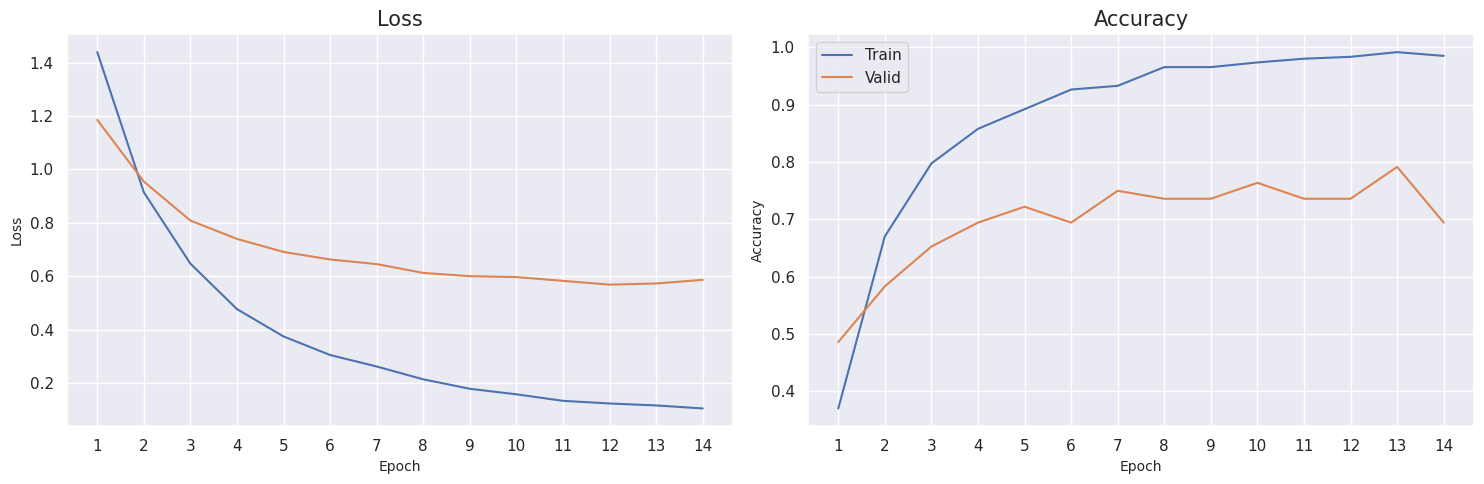

In [81]:
plot_results(history4.history['loss'], history4.history['accuracy'], history4.history['val_loss'], history4.history['val_accuracy'])

In [75]:
model5 = Sequential()

In [76]:
model5.add(Input(shape = (80, 80, 3)))
model5.add(Conv2D(16, (3, 3), padding = 'same'))
model5.add(BatchNormalization())
model5.add(ReLU())
model5.add(MaxPooling2D(pool_size = (2, 2)))
model5.add(Flatten())
model5.add(Dense(len(class_names), activation = 'softmax'))

In [77]:
model5.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

In [78]:
model5.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_13 (Conv2D)                   │ (None, 80, 80, 16)          │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 80, 80, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu (ReLU)                         │ (None, 80, 80, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 40, 40, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_8 (Flatten)                  │ (None, 25600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 4)                   │         102,404 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 102,916 (402.02 KB)

 Trainable params: 102,884 (401.89 KB)

 Non-trainable params: 32 (128.00 B)

In [79]:
early_stopping5 = EarlyStopping(monitor = 'val_loss', patience = 2)

In [80]:
history5 = model5.fit(train_dataset, validation_data = valid_dataset, epochs = 100, callbacks = [early_stopping5])

Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - accuracy: 0.3771 - loss: 4.7348 - val_accuracy: 0.1667 - val_loss: 1.6736
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7222 - loss: 1.1525 - val_accuracy: 0.5417 - val_loss: 1.1773
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8048 - loss: 0.6297 - val_accuracy: 0.4167 - val_loss: 1.3355
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8594 - loss: 0.4423 - val_accuracy: 0.5000 - val_loss: 1.0995
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8712 - loss: 0.4574 - val_accuracy: 0.5417 - val_loss: 0.9633
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9866 - loss: 0.0481 - val_accuracy: 0.6528 - val_loss: 0.8067
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9835 - loss: 0.0975 - val_accuracy: 0.7222 - val_loss: 0.7444
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9868 - loss: 0.1057 - val_accuracy: 0.7361 - 

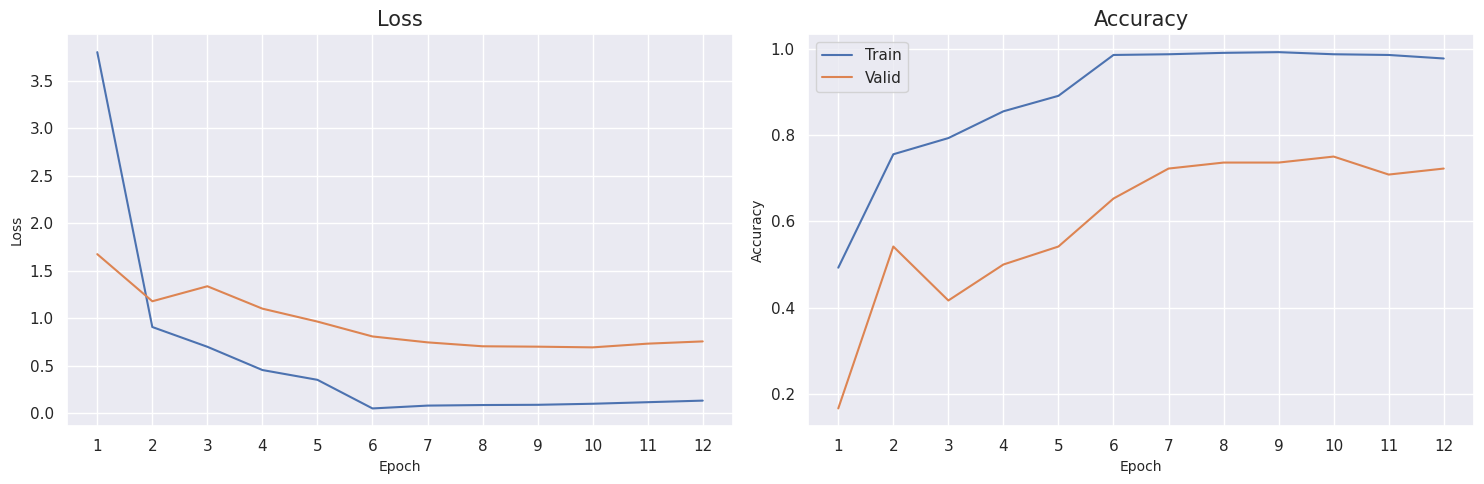

In [82]:
plot_results(history5.history['loss'], history5.history['accuracy'], history5.history['val_loss'], history5.history['val_accuracy'])

In [32]:
model6 = Sequential()

In [33]:
model6.add(Conv2D(16, (3, 3), padding = 'same', kernel_regularizer = regularizers.l1(0.01)))
model6.add(BatchNormalization())
model6.add(ReLU())
model6.add(MaxPooling2D(pool_size = (2, 2)))
model6.add(Flatten())
model6.add(Dropout(0.5))
model6.add(Dense(len(class_names), activation = 'softmax'))

In [34]:
model6.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

In [35]:
model6.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu (ReLU)                         │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [36]:
early_stopping6 = EarlyStopping(monitor = 'val_loss', patience = 2)

In [37]:
history6 = model6.fit(train_dataset, validation_data = valid_dataset, epochs = 100, callbacks = [early_stopping6])

Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 0.4311 - loss: 5.1464 - val_accuracy: 0.2083 - val_loss: 1.7333
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7004 - loss: 1.5966 - val_accuracy: 0.4444 - val_loss: 1.5720
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8541 - loss: 0.8150 - val_accuracy: 0.4861 - val_loss: 1.4663
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9102 - loss: 0.6377 - val_accuracy: 0.5694 - val_loss: 1.3747
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9373 - loss: 0.5048 - val_accuracy: 0.5556 - val_loss: 1.3282
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9375 - loss: 0.5436 - val_accuracy: 0.4861 - val_loss: 1.3288
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9641 - loss: 0.4357 - val_accuracy: 0.4444 - val_loss: 1.3482


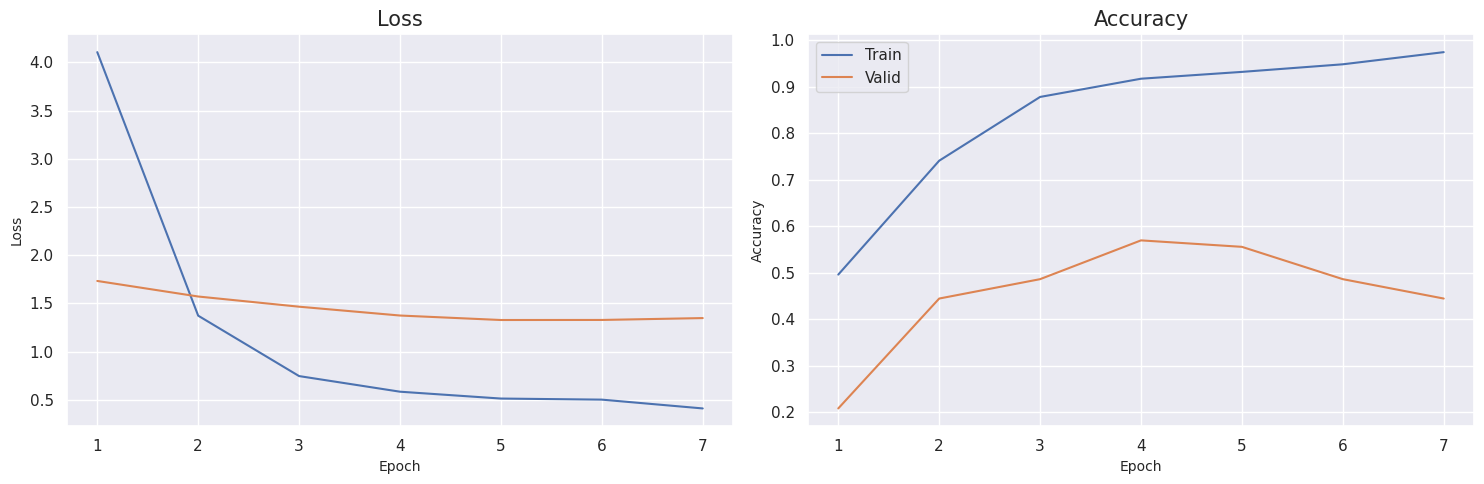

In [40]:
plot_results(history6.history['loss'], history6.history['accuracy'], history6.history['val_loss'], history6.history['val_accuracy'])

In [56]:
base_model = ResNet50(weights = 'imagenet', include_top = False, input_shape = (80, 80, 3))

In [57]:
for layer in base_model.layers:
    layer.trainable = False

In [58]:
model7 = Sequential()

In [59]:
model7.add(base_model)
model7.add(Flatten())
model7.add(Dense(len(class_names), activation = 'softmax'))

In [60]:
model7.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

In [61]:
early_stopping7 = EarlyStopping(monitor = 'val_loss', patience = 2)

In [62]:
history7 = model7.fit(train_dataset, validation_data = valid_dataset, epochs = 20)

Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 19s 398ms/step - accuracy: 0.4222 - loss: 1.3486 - val_accuracy: 0.4167 - val_loss: 1.2146
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5889 - loss: 0.9295 - val_accuracy: 0.4722 - val_loss: 1.2703
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6094 - loss: 0.8162 - val_accuracy: 0.5000 - val_loss: 1.2065
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6556 - loss: 0.7616 - val_accuracy: 0.5278 - val_loss: 1.1987
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6756 - loss: 0.7151 - val_accuracy: 0.5139 - val_loss: 1.1971
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7045 - loss: 0.6737 - val_accuracy: 0.5000 - val_loss: 1.1969
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7416 - loss: 0.6419 - val_accuracy: 0.5278 - val_loss: 1.1939
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7576 - loss: 0.6149 - val_accuracy: 0.5417 -

In [423]:
transform = A.Compose([
    A.Rotate(limit = (-10, 10))
])

In [424]:
aug = transform(image = images_array[0])['image']

(-0.5, 79.5, 79.5, -0.5)

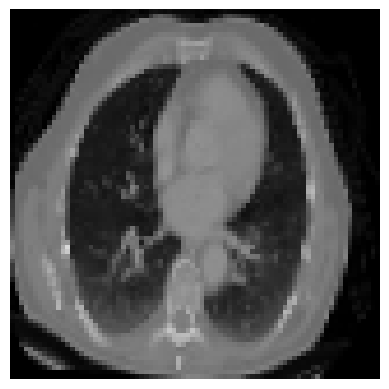

In [425]:
plt.imshow(aug.astype('uint32'))
plt.axis('off')

(-0.5, 79.5, 79.5, -0.5)

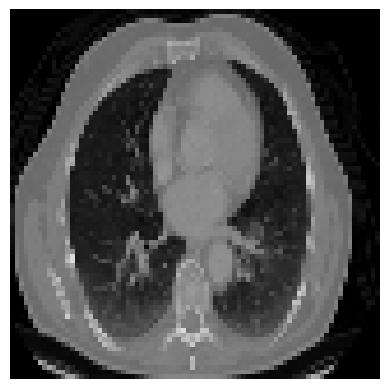

In [394]:
plt.imshow(images_array[0].astype('uint32'))
plt.axis('off')

In [576]:
images, labels = [], []
for i in os.listdir('/kaggle/input/chest-ctscan-images/Data/train'):
    for j in os.listdir(os.path.join('/kaggle/input/chest-ctscan-images/Data/train', i)):
        path = os.path.join('/kaggle/input/chest-ctscan-images/Data/train', i, j)
        img = cv2.imread(path)
        if img is None:
            print(path)
        else:
            resized_img = cv2.resize(img, (80, 80))
            images.append(resized_img)
            labels.append(i)
            tr1 = A.Perspective(scale = 0.05, p = 1)
            images.append(tr1(image = resized_img)['image'])
            labels.append(i)
            tr2 = A.ShiftScaleRotate(shift_limit = (0.03, 0.05), rotate_limit = (3, 7), p = 1)
            images.append(tr2(image = resized_img)['image'])
            labels.append(i)
            tr3 = A.OpticalDistortion(distort_limit = (0.9, 0.9), p = 1)
            images.append(tr3(image = resized_img)['image'])
            labels.append(i)
            tr4 = A.PixelDropout(p = 1)
            images.append(tr4(image = resized_img)['image'])
            labels.append(i)
            tr5 = A.Rotate(limit = (-10, 10), p = 1)
            images.append(tr5(image = resized_img)['image'])
            labels.append(i)
            tr6 = A.Affine(scale = (0.5, 1.5), rotate = (-20, 20))
            images.append(tr6(image = resized_img)['image'])
            labels.append(i)
            tr7 = A.ElasticTransform()
            images.append(tr7(image = resized_img)['image'])
            labels.append(i)
            tr8 = A.GridDistortion()
            images.append(tr8(image = resized_img)['image'])
            labels.append(i)

In [577]:
len(images)

5517

In [578]:
len(labels)

5517

In [579]:
len(images_array)

613

In [580]:
X, y = shuffle(images, labels, random_state = 101)

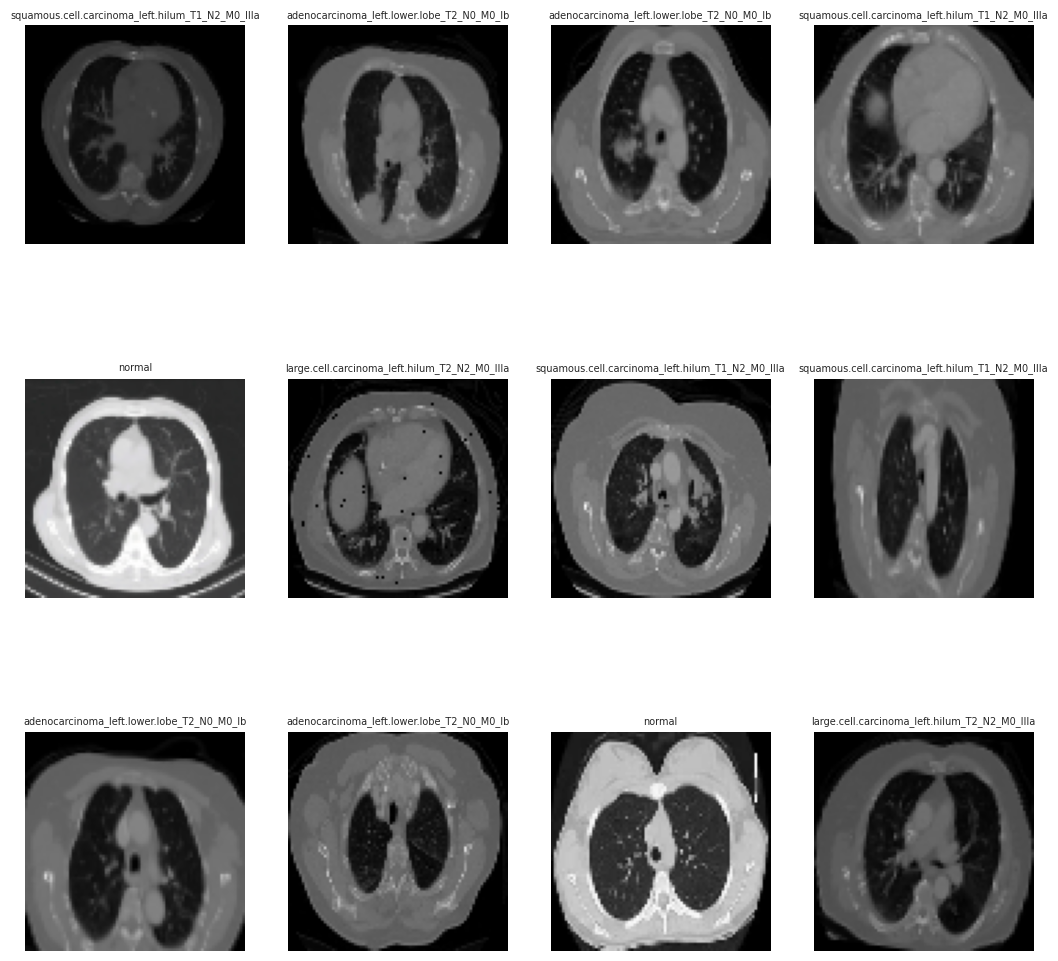

In [582]:
plt.figure(figsize = (13, 13))
for i in range(12):
    ax = plt.subplot(3, 4, i + 1)
    plt.imshow(X[i].astype('uint32'))
    plt.title(y[i], fontsize = 7)
    plt.axis('off')

In [583]:
v_images, v_labels = [], []
for i in os.listdir('/kaggle/input/chest-ctscan-images/Data/valid'):
    for j in os.listdir(os.path.join('/kaggle/input/chest-ctscan-images/Data/valid', i)):
        path = os.path.join('/kaggle/input/chest-ctscan-images/Data/valid', i, j)
        img = cv2.imread(path)
        if img is None:
            print(path)
        else:
            resized_img = cv2.resize(img, (80, 80))
            v_images.append(resized_img)
            v_labels.append(i)

In [584]:
le = LabelEncoder()

In [585]:
y_train = le.fit_transform(y)

In [586]:
y_valid = le.fit_transform(v_labels)

In [587]:
X_train = np.array(X)

In [588]:
X_valid = np.array(v_images)

In [589]:
X_train_scaled = X_train / 255

In [590]:
X_valid_scaled = X_valid / 255

In [631]:
base_model = ResNet50(weights = 'imagenet', include_top = False, input_shape = (80, 80, 3))

In [632]:
for layer in base_model.layers:
    layer.trainable = False

In [633]:
model8 = Sequential()

In [634]:
model8.add(base_model)
model8.add(Flatten())
model8.add(Dense(len(class_names), activation = 'softmax'))

In [635]:
model8.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

In [636]:
history8 = model8.fit(X_train_scaled, y_train, validation_data = (X_valid_scaled, y_valid), epochs = 20, batch_size = 32)

Epoch 1/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 24s 62ms/step - accuracy: 0.5478 - loss: 1.0127 - val_accuracy: 0.4861 - val_loss: 1.3498
Epoch 2/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.6915 - loss: 0.7225 - val_accuracy: 0.5278 - val_loss: 1.0714
Epoch 3/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.7446 - loss: 0.6161 - val_accuracy: 0.5556 - val_loss: 0.9789
Epoch 4/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.7745 - loss: 0.5560 - val_accuracy: 0.4861 - val_loss: 1.0656
Epoch 5/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.8005 - loss: 0.5145 - val_accuracy: 0.6111 - val_loss: 0.9201
Epoch 6/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.8001 - loss: 0.4997 - val_accuracy: 0.5694 - val_loss: 0.9277
Epoch 7/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.8143 - loss: 0.4637 - val_accuracy: 0.5833 - val_loss: 0.9382
Epoch 8/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.8309 - loss: 0.4394 - val_acc

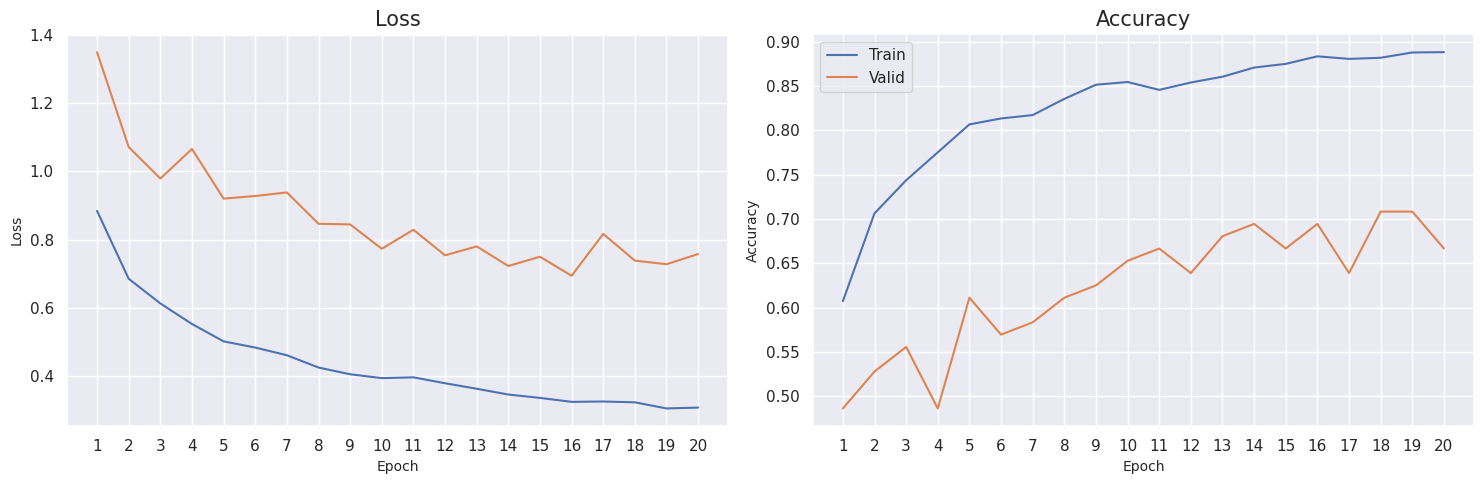

In [637]:
plot_results(history8.history['loss'], history8.history['accuracy'], history8.history['val_loss'], history8.history['val_accuracy'])

In [644]:
base_model2 = VGG16(weights = 'imagenet', include_top = False, input_shape = (80, 80, 3))

In [645]:
for layer in base_model2.layers:
    layer.trainable = False

In [646]:
model9 = Sequential()

In [647]:
model9.add(base_model2)
model9.add(Flatten())
model9.add(Dropout(0.5))
model9.add(Dense(len(class_names), activation = 'softmax'))

In [648]:
model9.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

In [649]:
history9 = model9.fit(X_train_scaled, y_train, validation_data = (X_valid_scaled, y_valid), epochs = 10, batch_size = 32)

Epoch 1/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - accuracy: 0.4696 - loss: 1.2077 - val_accuracy: 0.5833 - val_loss: 0.8871
Epoch 2/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - accuracy: 0.7161 - loss: 0.7329 - val_accuracy: 0.6944 - val_loss: 0.7680
Epoch 3/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy: 0.7634 - loss: 0.6233 - val_accuracy: 0.7361 - val_loss: 0.6654
Epoch 4/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - accuracy: 0.8104 - loss: 0.5385 - val_accuracy: 0.7917 - val_loss: 0.6121
Epoch 5/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.8210 - loss: 0.5028 - val_accuracy: 0.7500 - val_loss: 0.5950
Epoch 6/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.8280 - loss: 0.4853 - val_accuracy: 0.7222 - val_loss: 0.6255
Epoch 7/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy: 0.8352 - loss: 0.4542 - val_accuracy: 0.7917 - val_loss: 0.5531
Epoch 8/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - accuracy: 0.8345 - loss: 0.4461 - val_acc

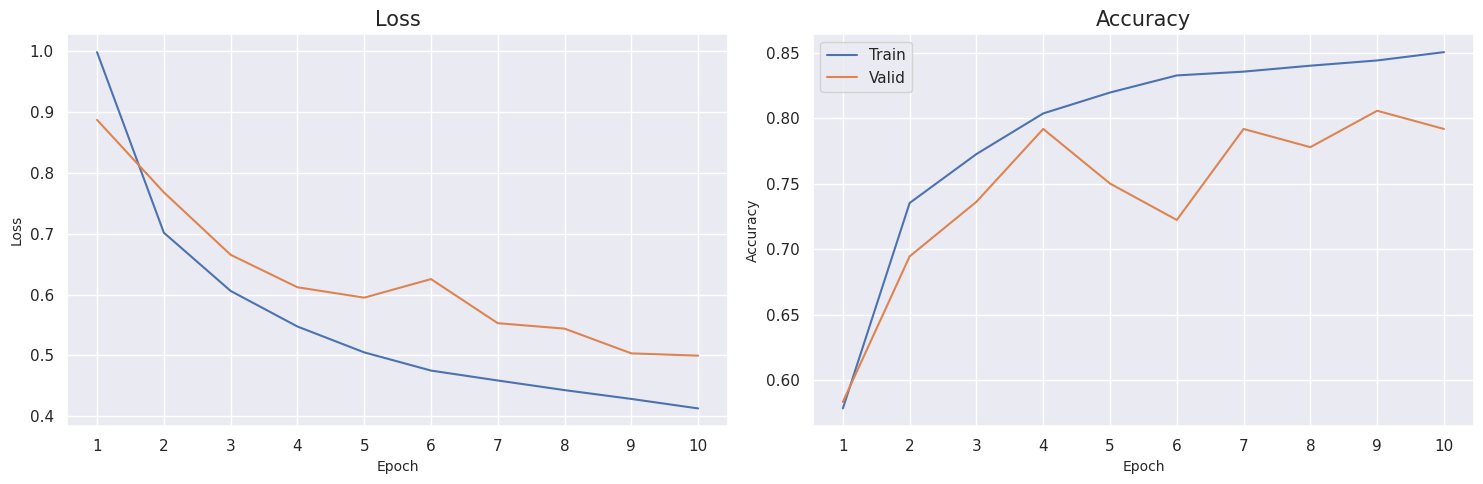

In [650]:
plot_results(history9.history['loss'], history9.history['accuracy'], history9.history['val_loss'], history9.history['val_accuracy'])

In [651]:
model9.evaluate(X_test_scaled, y_test)

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 345ms/step - accuracy: 0.5450 - loss: 1.0116


[0.928368091583252, 0.60317462682724]

In [660]:
base_model3 = DenseNet121(weights = 'imagenet', include_top = False, input_shape = (80, 80, 3))

In [661]:
for layer in base_model3.layers:
    layer.trainable = False

In [662]:
model10 = Sequential()

In [663]:
model10.add(base_model3)
model10.add(Flatten())
model10.add(BatchNormalization())
model10.add(Dropout(0.5))
model10.add(Dense(len(class_names), activation = 'softmax'))

In [664]:
model10.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

In [665]:
history10 = model10.fit(X_train_scaled, y_train, validation_data = (X_valid_scaled, y_valid), epochs = 3, batch_size = 64)

Epoch 1/3
87/87 ━━━━━━━━━━━━━━━━━━━━ 51s 286ms/step - accuracy: 0.5582 - loss: 1.1460 - val_accuracy: 0.6944 - val_loss: 0.6256
Epoch 2/3
87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.7887 - loss: 0.5328 - val_accuracy: 0.8194 - val_loss: 0.4569
Epoch 3/3
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.8707 - loss: 0.3730 - val_accuracy: 0.7639 - val_loss: 0.4716


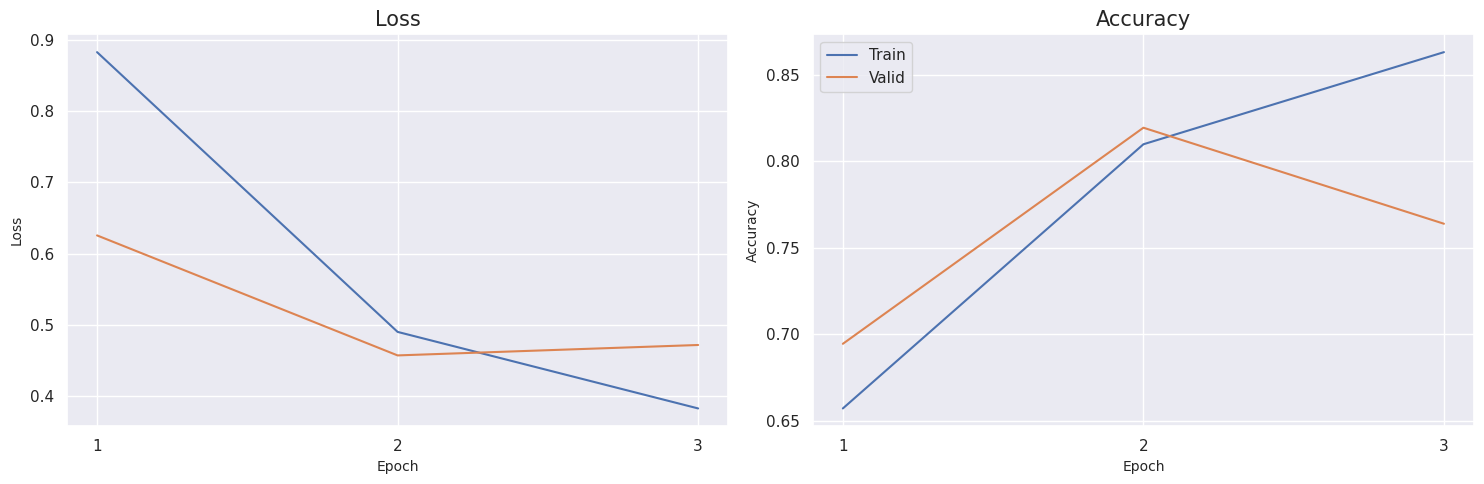

In [666]:
plot_results(history10.history['loss'], history10.history['accuracy'], history10.history['val_loss'], history10.history['val_accuracy'])

In [538]:
t_images, t_labels = [], []
for i in os.listdir('/kaggle/input/chest-ctscan-images/Data/test'):
    for j in os.listdir(os.path.join('/kaggle/input/chest-ctscan-images/Data/test', i)):
        path = os.path.join('/kaggle/input/chest-ctscan-images/Data/test', i, j)
        img = cv2.imread(path)
        if img is None:
            print(path)
        else:
            resized_img = cv2.resize(img, (80, 80))
            t_images.append(resized_img)
            t_labels.append(i)

In [539]:
y_test = le.fit_transform(t_labels)

In [540]:
X_test = np.array(t_images)

In [541]:
X_test_scaled = X_test / 255

In [667]:
model10.evaluate(X_test_scaled, y_test)

10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 617ms/step - accuracy: 0.6060 - loss: 0.8456


[0.7564996480941772, 0.6634920835494995]

In [556]:
base_model4 = EfficientNetV2L(weights = 'imagenet', include_top = False, input_shape = (80, 80, 3))

In [557]:
for layer in base_model4.layers:
    layer.trainable = False

In [558]:
model11 = Sequential()

In [559]:
model11.add(base_model4)
model11.add(Flatten())
model11.add(Dense(len(class_names), activation = 'softmax'))

In [560]:
model11.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

In [561]:
history11 = model11.fit(X_train_scaled, y_train, validation_data = (X_valid_scaled, y_valid), epochs = 20, batch_size = 32)

Epoch 1/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 186s 693ms/step - accuracy: 0.3619 - loss: 1.4818 - val_accuracy: 0.3889 - val_loss: 1.2260
Epoch 2/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step - accuracy: 0.4514 - loss: 1.2324 - val_accuracy: 0.4306 - val_loss: 1.4501
Epoch 3/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - accuracy: 0.4964 - loss: 1.1492 - val_accuracy: 0.3889 - val_loss: 1.1691
Epoch 4/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - accuracy: 0.4793 - loss: 1.1781 - val_accuracy: 0.4444 - val_loss: 1.4731
Epoch 5/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 8s 70ms/step - accuracy: 0.4883 - loss: 1.1720 - val_accuracy: 0.3611 - val_loss: 1.1990
Epoch 6/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 8s 71ms/step - accuracy: 0.4951 - loss: 1.1131 - val_accuracy: 0.4167 - val_loss: 1.1792
Epoch 7/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 8s 71ms/step - accuracy: 0.4994 - loss: 1.1220 - val_accuracy: 0.4444 - val_loss: 1.1893
Epoch 8/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 8s 73ms/step - accuracy: 0.5247 - loss: 1.0771 - val_a

In [564]:
base_model5 = InceptionV3(weights = 'imagenet', include_top = False, input_shape = (80, 80, 3))

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [565]:
for layer in base_model5.layers:
    layer.trainable = False

In [566]:
model12 = Sequential()

In [567]:
model12.add(base_model5)
model12.add(Flatten())
model12.add(Dense(len(class_names), activation = 'softmax'))

In [568]:
model12.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

In [569]:
history12 = model12.fit(X_train_scaled, y_train, validation_data = (X_valid_scaled, y_valid), epochs = 20, batch_size = 32)

Epoch 1/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 33s 149ms/step - accuracy: 0.4468 - loss: 1.2444 - val_accuracy: 0.5556 - val_loss: 0.9895
Epoch 2/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7144 - loss: 0.7298 - val_accuracy: 0.6806 - val_loss: 0.8780
Epoch 3/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7630 - loss: 0.6201 - val_accuracy: 0.6389 - val_loss: 0.8370
Epoch 4/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8261 - loss: 0.5086 - val_accuracy: 0.6667 - val_loss: 0.8319
Epoch 5/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8242 - loss: 0.4938 - val_accuracy: 0.6389 - val_loss: 0.8823
Epoch 6/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8295 - loss: 0.4650 - val_accuracy: 0.6806 - val_loss: 0.7979
Epoch 7/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8570 - loss: 0.4160 - val_accuracy: 0.6944 - val_loss: 0.8028
Epoch 8/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8414 - loss: 0.4152 - val_ac

In [699]:
model13 = Sequential()

In [700]:
model13.add(Input(shape = (80, 80, 3)))
model13.add(Conv2D(16, (3, 3), padding = 'same'))
model13.add(BatchNormalization())
model13.add(ReLU())
model13.add(MaxPooling2D(pool_size = (2, 2)))
model13.add(Flatten())
model13.add(Dropout(0.5))
model13.add(Dense(len(class_names), activation = 'softmax'))

In [701]:
model13.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

In [702]:
early_stopping14 = EarlyStopping(monitor = 'val_loss', patience = 2)

In [703]:
history13 = model13.fit(X_train_scaled, y_train, validation_data = (X_valid_scaled, y_valid), epochs = 20, callbacks = [early_stopping14])

Epoch 1/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.5900 - loss: 2.0672 - val_accuracy: 0.5139 - val_loss: 1.0380
Epoch 2/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8337 - loss: 0.5025 - val_accuracy: 0.5833 - val_loss: 1.0388
Epoch 3/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8906 - loss: 0.3283 - val_accuracy: 0.7083 - val_loss: 0.7170
Epoch 4/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9105 - loss: 0.2816 - val_accuracy: 0.7222 - val_loss: 0.9788
Epoch 5/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9215 - loss: 0.2107 - val_accuracy: 0.8056 - val_loss: 0.7340


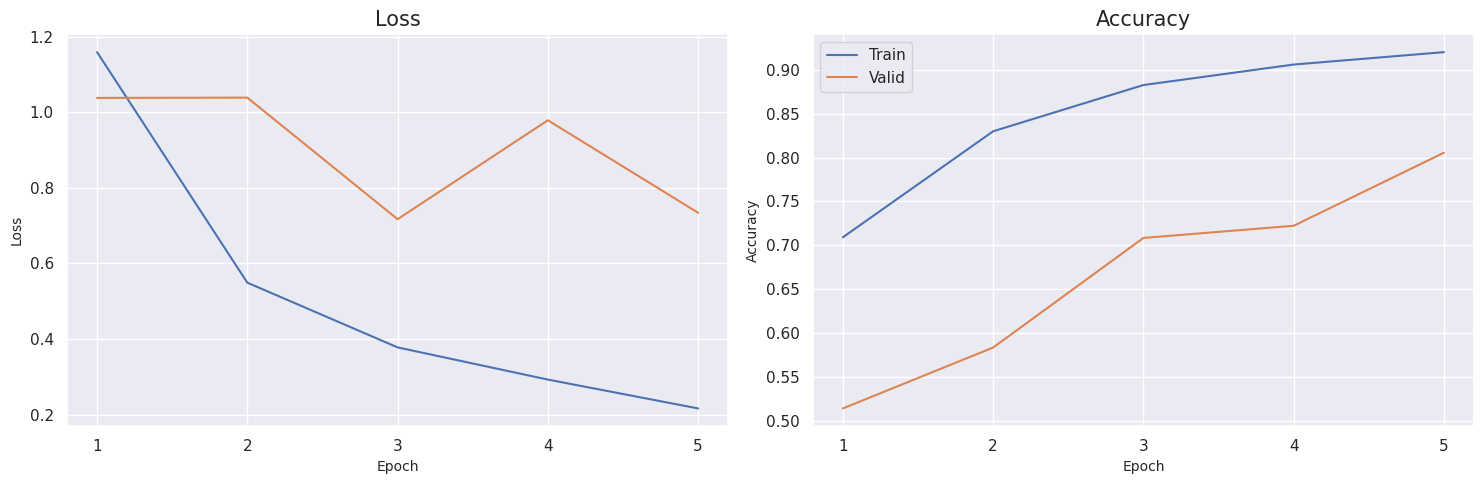

In [704]:
plot_results(history13.history['loss'], history13.history['accuracy'], history13.history['val_loss'], history13.history['val_accuracy'])

In [706]:
model15 = Sequential()

In [707]:
model15.add(Input(shape = (80, 80, 3)))
model15.add(Conv2D(16, (3, 3), padding = 'same'))
model15.add(ReLU())
model15.add(MaxPooling2D(pool_size = (2, 2)))
model15.add(Flatten())
model15.add(Dropout(0.5))
model15.add(Dense(len(class_names), activation = 'softmax'))

In [708]:
model15.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

In [709]:
early_stopping15 = EarlyStopping(monitor = 'val_loss', patience = 2)

In [710]:
history15 = model15.fit(X_train_scaled, y_train, validation_data = (X_valid_scaled, y_valid), epochs = 20, callbacks = [early_stopping15])

Epoch 1/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.5572 - loss: 1.0207 - val_accuracy: 0.7083 - val_loss: 0.6782
Epoch 2/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8609 - loss: 0.4271 - val_accuracy: 0.7361 - val_loss: 0.5884
Epoch 3/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9124 - loss: 0.2789 - val_accuracy: 0.7917 - val_loss: 0.5618
Epoch 4/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9265 - loss: 0.2187 - val_accuracy: 0.7639 - val_loss: 0.7076
Epoch 5/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9449 - loss: 0.1758 - val_accuracy: 0.7778 - val_loss: 0.4755
Epoch 6/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9531 - loss: 0.1445 - val_accuracy: 0.7778 - val_loss: 0.5921
Epoch 7/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9624 - loss: 0.1218 - val_accuracy: 0.8472 - val_loss: 0.4375
Epoch 8/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9654 - loss: 0.1145 - val_accuracy: 0

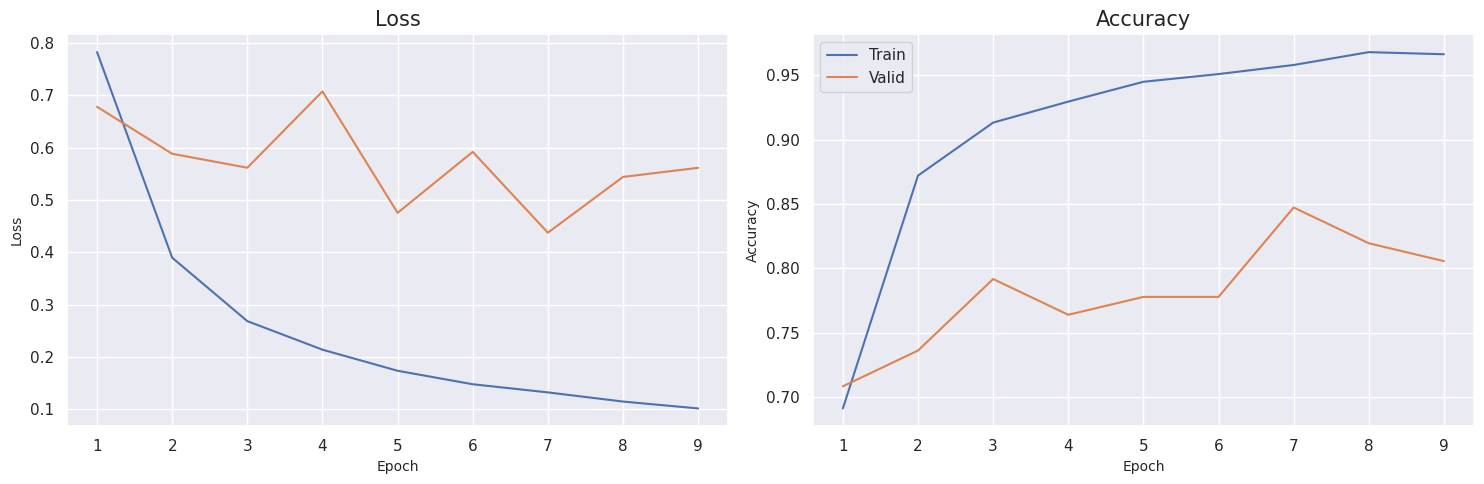

In [716]:
plot_results(history15.history['loss'], history15.history['accuracy'], history15.history['val_loss'], history15.history['val_accuracy'])

In [754]:
model16 = Sequential()

In [755]:
model16.add(Input(shape = (80, 80, 3)))
model16.add(Conv2D(16, (3, 3), padding = 'same'))
model16.add(ReLU())
model16.add(Dropout(0.9))
model16.add(MaxPooling2D(pool_size = (2, 2)))
model16.add(Flatten())
model16.add(Dropout(0.7))
model16.add(Dense(len(class_names), activation = 'softmax'))

In [756]:
model16.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

In [757]:
early_stopping16 = EarlyStopping(monitor = 'val_loss', patience = 2)

In [758]:
history16 = model16.fit(X_train_scaled, y_train, validation_data = (X_valid_scaled, y_valid), epochs = 20, callbacks = [early_stopping16])

Epoch 1/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.4423 - loss: 1.2725 - val_accuracy: 0.6111 - val_loss: 0.9450
Epoch 2/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6798 - loss: 0.7619 - val_accuracy: 0.7639 - val_loss: 0.8429
Epoch 3/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7483 - loss: 0.6310 - val_accuracy: 0.7361 - val_loss: 0.7640
Epoch 4/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7623 - loss: 0.5959 - val_accuracy: 0.7917 - val_loss: 0.7478
Epoch 5/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7866 - loss: 0.5521 - val_accuracy: 0.8056 - val_loss: 0.7089
Epoch 6/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7897 - loss: 0.5217 - val_accuracy: 0.8194 - val_loss: 0.6898
Epoch 7/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8052 - loss: 0.5103 - val_accuracy: 0.8056 - val_loss: 0.6735
Epoch 8/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7972 - loss: 0.5166 - val_accuracy: 0

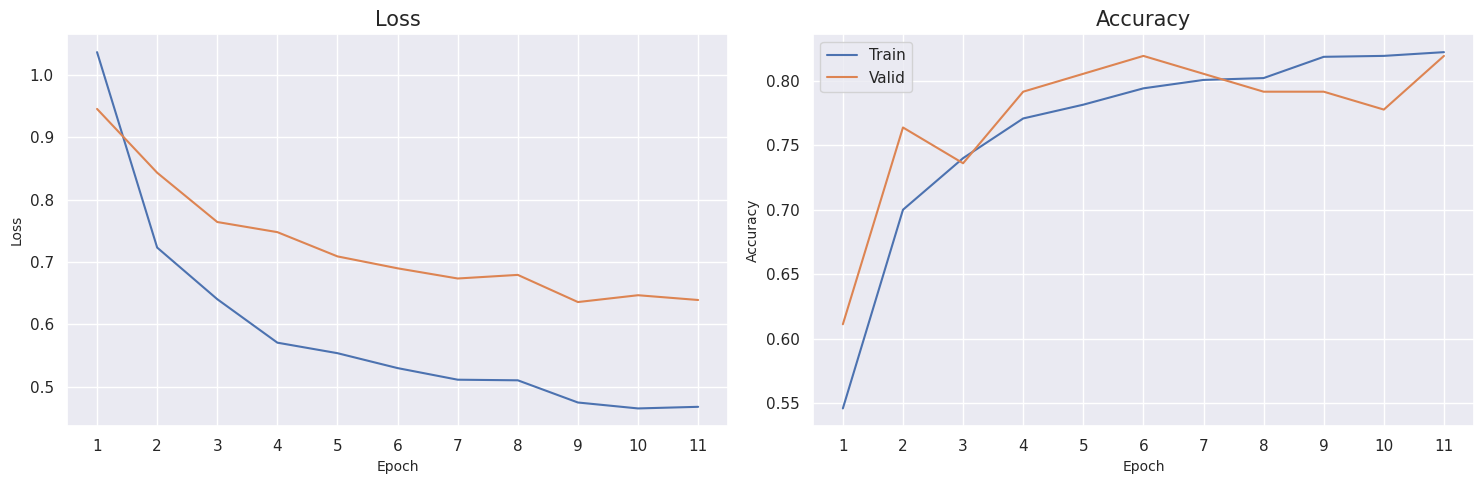

In [765]:
plot_results(history16.history['loss'], history16.history['accuracy'], history16.history['val_loss'], history16.history['val_accuracy'])

In [760]:
model17 = Sequential()

In [761]:
model17.add(Input(shape = (80, 80, 3)))
model17.add(Conv2D(16, (3, 3), padding = 'same'))
model17.add(ReLU())
model17.add(Dropout(0.9))
model17.add(MaxPooling2D(pool_size = (2, 2)))
model17.add(Flatten())
model17.add(Dropout(0.7))
model17.add(Dense(len(class_names), activation = 'softmax'))

In [762]:
model17.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

In [763]:
early_stopping17 = EarlyStopping(monitor = 'val_loss', patience = 2)

In [764]:
history17 = model17.fit(train_dataset, validation_data = valid_dataset, epochs = 20, callbacks = [early_stopping17])

Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 160ms/step - accuracy: 0.2992 - loss: 2.2619 - val_accuracy: 0.4167 - val_loss: 1.3176
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4425 - loss: 1.1494 - val_accuracy: 0.5139 - val_loss: 1.2171
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5773 - loss: 0.9780 - val_accuracy: 0.5833 - val_loss: 1.0953
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6136 - loss: 0.8755 - val_accuracy: 0.5972 - val_loss: 1.0164
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6944 - loss: 0.7498 - val_accuracy: 0.5972 - val_loss: 0.9665
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7298 - loss: 0.6568 - val_accuracy: 0.6806 - val_loss: 0.9142
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7444 - loss: 0.6248 - val_accuracy: 0.6806 - val_loss: 0.8871
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7564 - loss: 0.5514 - val_accuracy: 0.7222 - val_los

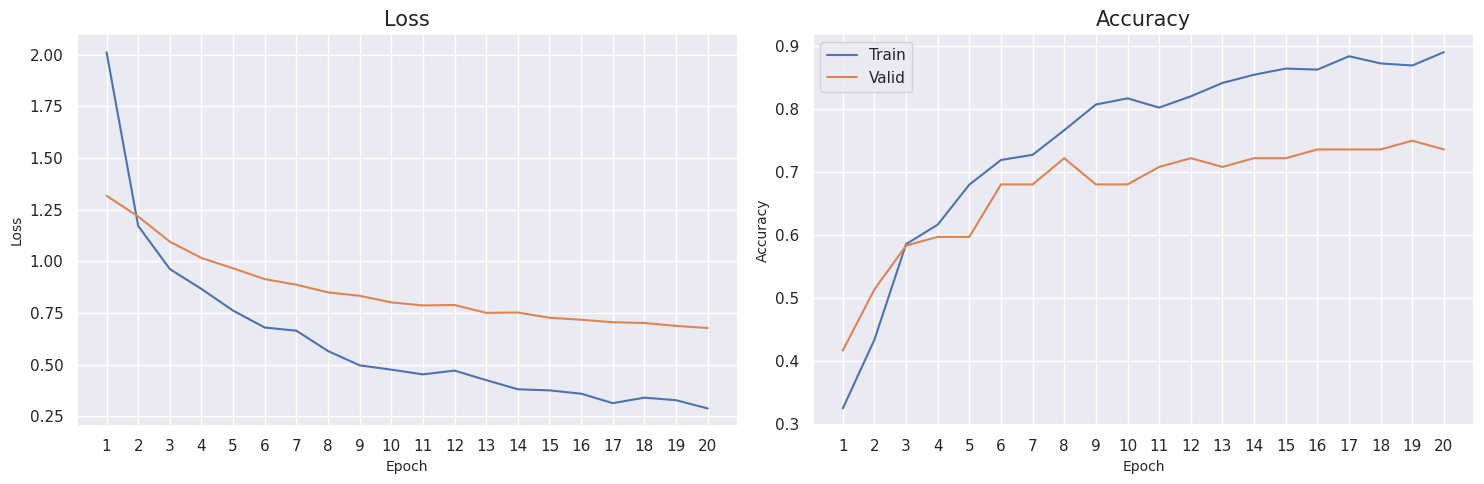

In [766]:
plot_results(history17.history['loss'], history17.history['accuracy'], history17.history['val_loss'], history17.history['val_accuracy'])